In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from halton_points import HaltonPoints
from function_Fm import *
from explicit_RK import *

## Boundary

In [2]:
nf = 4
r = HaltonPoints(2, nf).haltonPoints()
fxl = r.copy()
fxl[:, 0] = 0
fxr = r.copy()
fxr[:, 0] = 1
fyu = r.copy()
fyu[:, 1] = 0
fyd = r.copy()
fyd[:, 1] = 1
Mb = np.vstack((fxl, fxr, fyu, fyd))

boundary_points = pd.DataFrame(Mb, columns=['x', 'y'])
boundary_points['Collocation'] = 'Boundary'

## Interior

In [3]:
poly_b = np.array([[-1, -1, 1], [1/2, 3/2, -1], [3/2, 1/8, -3/8]])
npnts = 7

uh = assembled_matrix(Mb=Mb, npnts=npnts, poly_b=poly_b, rbf='MQ')
X0 = uh.X_0()

interior_points = pd.DataFrame(uh.Mi, columns=['x', 'y'])
interior_points['Collocation'] = 'Interior'

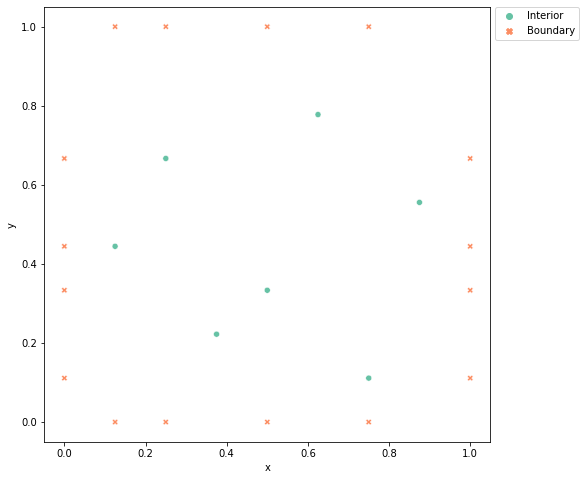

In [4]:
points = pd.concat([interior_points, boundary_points])
plt.figure(figsize=(8,8))
sns.scatterplot(x='x', y='y', data=points, hue='Collocation', style='Collocation', palette='Set2')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [10]:
t0, te = 0, 0.5
N = 20
uh.alpha = 0.8
X0 = uh.X_0()
exp_RK = explicit_RungeKutta(Fm, X0, t0, te, N, uh)

In [11]:
X0

array([[0.32971635, 0.2198109 ],
       [0.16130475, 0.43014601],
       [0.47894471, 0.07095477],
       [0.08422709, 0.2994741 ],
       [0.37345444, 0.4647433 ],
       [0.25352357, 0.15023619],
       [0.516128  , 0.32770032]])

In [12]:
exp_RK.solve()

In [13]:
exp_RK.solution[1]

array([[0.32424074, 0.21626249],
       [0.15582914, 0.42659759],
       [0.47346909, 0.06740636],
       [0.07875147, 0.29592568],
       [0.36797882, 0.46119488],
       [0.24804795, 0.14668777],
       [0.51065238, 0.3241519 ]])

In [15]:
np.linspace(t0, te,N+1)

array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
       0.45 , 0.475, 0.5  ])

In [26]:
X0 + 0.025*Fm(0.025, X0, uh) - exp_RK.solution[1]

array([[0.00075269, 0.00066907],
       [0.00075269, 0.00066907],
       [0.00075269, 0.00066907],
       [0.00075269, 0.00066907],
       [0.00075269, 0.00066907],
       [0.00075269, 0.00066907],
       [0.00075269, 0.00066907]])

In [25]:
norm_x = np.linalg.norm(uh.Mi, axis=1).reshape(-1,1)
ex = u(uh.Mi, norm_x, 0.025)
abs(ex - exp_RK.solution[3])/ex * 100
ex

array([[0.31559042, 0.21039361],
       [0.15445057, 0.41186818],
       [0.4586763 , 0.06795204],
       [0.08059112, 0.28654621],
       [0.35810507, 0.44564187],
       [0.24256705, 0.14374344],
       [0.4950466 , 0.3143153 ]])

In [ ]:
for k,i in enumerate(np.linspace(0,1,N+1)):
    if k%20==0:
        print("{:,.0f}. {:,.4f}".format(k, i))


In [17]:
def plot_solution(M, Mi, i):
    n = int(M.shape[0]/Mi.shape[0])
    df_i = pd.DataFrame()
    for _ in range(n):
        df_i = pd.concat([df_i, pd.DataFrame(Mi, columns=['x', 'y'])])
    df_i = df_i.reset_index().rename(columns={'index': 'i'})
    df = pd.DataFrame(M, columns=['u', 'v', 't'])
    df = pd.concat([df_i, df], axis=1)
    dff = df.loc[df['i'] == i]
    plt.figure(figsize=(8, 8))
    sns.lineplot(x='t', y='v', data=dff)
    return df

def u(Mi, norm_x, t, alpha=0.8):
    return Mi/((t+alpha) + (t+alpha)**2 * np.exp(norm_x**2/(4*(alpha +t))))

In [ ]:
norm_x = np.linalg.norm(uh.Mi, axis=1).reshape(-1,1)
ex = u(uh.Mi, norm_x, 1.)
abs(ex - exp_RK.solution[40])/ex * 100
ex

## Exact solution

In [ ]:
norm_x = np.linalg.norm(uh.Mi, axis=1).reshape(-1,1)
ni = uh.Mi.shape[0]
u0= u(uh.Mi, norm_x, 0.)
u0 = np.hstack((u0, np.array([0.]*ni).reshape(-1,1)))
for t in timegrid[1:]:
    ui= u(uh.Mi, norm_x, t)
    ui = np.hstack((ui, np.array([t]*ni).reshape(-1,1)))
    u0 = np.vstack((u0, ui))

exact_sol = plot_solution(u0, uh.Mi, 0)

In [ ]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(0, 1, 0.025)
Y = np.arange(0, 1, 0.025)
n_X = np.linalg.norm(np.hstack((X.reshape(-1,1), Y.reshape(-1,1))), axis=1).reshape(-1,1)
X, Y = np.meshgrid(X, Y)
t=0.05
V = Y/((1+t) + (1+t)*np.exp(n_X/(4*(1+t))))

# Plot the surface.
surf = ax.plot_surface(X, Y, V, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

In [ ]:
L, H = np.pi*np.mgrid[-1:1:1000j, -1:1:1000j]
T = np.cos(L)*np.cos(2*H)
H = np.cos(L) + H
fig, ax = plt.subplots()
surf = plt.contourf(L, H, T, cmap="hot")
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


In [ ]:
L, H = np.pi*np.mgrid[-1:1:10j, -1:1:10j]
L

In [ ]:
ti = exact_sol.t.unique()[5]
sol_i = exact_sol[exact_sol['t'] == ti][['u', 'v']].values

In [ ]:
app_u_i = X0 + ti*Fm(X0, uh)
np.mean(abs(sol_i- app_u_i)[:,0])

## Solution

In [ ]:
sol = FDM_time(timegrid, X0, uh)
for t, s in sol.items():
    print('Time: {:,.4f}'.format(t))
    print(s, '\n')